In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=1000) # just read first 1000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(14795, 4)

In [8]:
# looking for bad data
bad_data = 0
for i in range(len(data)):
    if(0.0 in data[i]):
        print(data[i])
        bad_data += 1

[1.14669609 0.38852206 2.76795745 0.        ]
[0.39850035 0.71061379 0.47403628 0.        ]
[ 1.03505492 -0.63787401 -2.29100299  0.        ]
[ 0.86411041 -1.07041073  0.51943153  0.        ]
[ 0.3633931   0.25732511 -2.30640078  0.        ]
[0.83586824 0.03770738 0.02798815 0.        ]
[ 0.75008154 -0.20511004  2.81549978  0.        ]
[0.68774503 2.13499832 1.63541198 0.        ]
[0.94247574 0.11074729 1.84531426 0.        ]
[1.07450008 1.1747762  3.01616168 0.        ]
[ 0.9007169   0.99564695 -0.63307905  0.        ]
[1.84172845 1.57989311 0.0058518  0.        ]
[ 0.64557874 -2.13930798 -0.2995446   0.        ]
[3.00485945 0.58341414 1.47977638 0.        ]
[ 0.59982067 -0.94319236 -2.62025762  0.        ]
[ 0.66232765 -0.55070883  1.12762892  0.        ]
[ 0.71634895 -1.78028464  2.07532454  0.        ]
[ 0.26076359 -0.53986913  2.90156698  0.        ]
[1.77076709 0.33344129 1.08254683 0.        ]
[1.38311613 0.0942976  0.13351126 0.        ]
[0.55915505 0.21554288 2.87588239 0.    

In [9]:
(bad_data, len(data))

(439, 14795)

In [10]:
# checking distribution of data
(data[:][1].mean(), data[:][1].std()) # eta

(344.6350920188037, 387.5184029169282)

In [11]:
# regularize
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim = 12
final_dim = 4
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [16]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [17]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [18]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [19]:
def vae_loss(x, y):
    xent_loss = metrics.binary_crossentropy(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [20]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           60          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            52          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            10          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):]
batch_size = 100
epochs = 200

In [23]:
x_train.shape

(11836, 4)

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Epoch 1/200
11836/11836 [==============================] - 1s 101us/step - loss: 0.6629
Epoch 2/200
11836/11836 [==============================] - 1s 47us/step - loss: 0.5341
Epoch 3/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4640
Epoch 4/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4561
Epoch 5/200
11836/11836 [==============================] - 1s 45us/step - loss: 0.4529
Epoch 6/200
11836/11836 [==============================] - 1s 45us/step - loss: 0.4520
Epoch 7/200
11836/11836 [==============================] - 1s 44us/step - loss: 0.4516
Epoch 8/200
11836/11836 [==============================] - 1s 44us/step - loss: 0.4512
Epoch 9/200
11836/11836 [==============================] - 1s 45us/step - loss: 0.4503
Epoch 10/200
11836/11836 [==============================] - 1s 45us/step - loss: 0.4506
Epoch 11/200
11836/11836 [==============================] - 1s 44us/step - loss: 0.4498
Epoch 12/200
11836/11836 [==============

11836/11836 [==============================] - 1s 43us/step - loss: 0.4488
Epoch 95/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 96/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 97/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 98/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 99/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 100/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487
Epoch 101/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487
Epoch 102/200
11836/11836 [==============================] - 1s 46us/step - loss: 0.4487
Epoch 103/200
11836/11836 [==============================] - 1s 47us/step - loss: 0.4488
Epoch 104/200
11836/11836 [==============================] - 1s 47us/step - loss: 0.4487
Epoch 105/200
11836/11836 [=============

11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 187/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 188/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 189/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 190/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 191/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 192/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 193/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 194/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 195/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 196/200
11836/11836 [==============================] - 1s 43us/step - loss: 0.4487
Epoch 197/200
11836/11836 [========

# Visualization

In [26]:
import matplotlib.pyplot as plt

In [38]:
predictions = vae.predict(x_val)

In [70]:
predictions

array([[0.0653072 , 0.4954865 , 0.4987857 , 0.0355328 ],
       [0.0655575 , 0.49956965, 0.5004322 , 0.03563962],
       [0.0593325 , 0.5003968 , 0.50112945, 0.03018194],
       ...,
       [0.06739371, 0.50141877, 0.49821195, 0.03670257],
       [0.06558774, 0.50235486, 0.49929884, 0.0350541 ],
       [0.06163107, 0.50127727, 0.50341344, 0.03231442]], dtype=float32)

In [40]:
distr = (x_val - predictions) / x_val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [52]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [53]:
pT = [row[0] for row in x_val]
eta = [row[1] for row in x_val]
phi = [row[2] for row in x_val]
mass = [row[3] for row in x_val]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([ 66.,  59.,  72., 145., 357., 698., 884., 518., 148.,  12.]),
 array([0.05898938, 0.06003422, 0.06107907, 0.06212391, 0.06316876,
        0.0642136 , 0.06525845, 0.0663033 , 0.06734814, 0.06839299,
        0.06943784], dtype=float32),
 <a list of 10 Patch objects>)

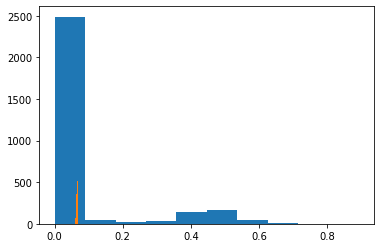

In [57]:
plt.hist(pT)
plt.hist(pT_pred)

(array([   2.,    8.,   43.,  117.,  297.,  400.,  586., 1008.,  490.,
           8.]),
 array([0.49318236, 0.49429217, 0.49540198, 0.4965118 , 0.4976216 ,
        0.4987314 , 0.4998412 , 0.50095105, 0.50206083, 0.5031706 ,
        0.50428045], dtype=float32),
 <a list of 10 Patch objects>)

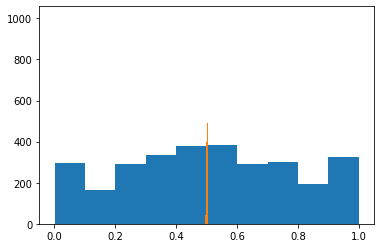

In [58]:
plt.hist(eta)
plt.hist(eta_pred)

(array([3.37e+02, 1.21e+03, 8.42e+02, 3.01e+02, 1.05e+02, 6.70e+01,
        5.10e+01, 3.20e+01, 1.30e+01, 1.00e+00]),
 array([0.49734768, 0.4984444 , 0.4995411 , 0.5006378 , 0.50173455,
        0.5028313 , 0.503928  , 0.5050247 , 0.5061214 , 0.5072181 ,
        0.50831485], dtype=float32),
 <a list of 10 Patch objects>)

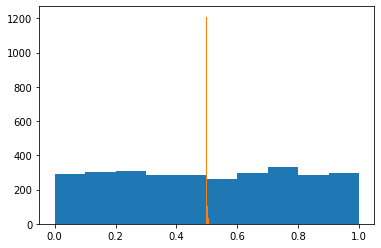

In [60]:
plt.hist(phi)
plt.hist(phi_pred)

(array([ 46.,  67.,  80., 147., 338., 643., 855., 570., 197.,  16.]),
 array([0.03000546, 0.03083546, 0.03166547, 0.03249547, 0.03332547,
        0.03415548, 0.03498548, 0.03581549, 0.03664549, 0.0374755 ,
        0.0383055 ], dtype=float32),
 <a list of 10 Patch objects>)

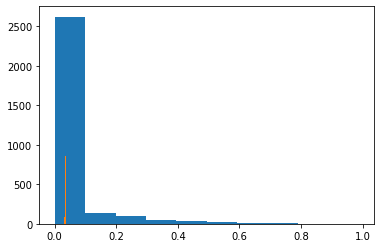

In [61]:
plt.hist(mass)
plt.hist(mass_pred)

In [63]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

(array([1.0e+00, 0.0e+00, 0.0e+00, 2.0e+00, 0.0e+00, 2.0e+00, 4.0e+00,
        6.0e+00, 4.4e+01, 2.9e+03]),
 array([-1.66200105e+04, -1.49579167e+04, -1.32958229e+04, -1.16337291e+04,
        -9.97163523e+03, -8.30954140e+03, -6.64744757e+03, -4.98535374e+03,
        -3.32325991e+03, -1.66116608e+03,  9.27754080e-01]),
 <a list of 10 Patch objects>)

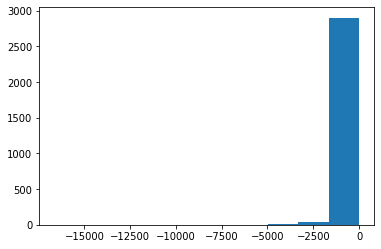

In [64]:
plt.hist(d_pT)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.955e+03]),
 array([-3.23097237e+03, -2.90782489e+03, -2.58467741e+03, -2.26152993e+03,
        -1.93838245e+03, -1.61523498e+03, -1.29208750e+03, -9.68940017e+02,
        -6.45792538e+02, -3.22645058e+02,  5.02421170e-01]),
 <a list of 10 Patch objects>)

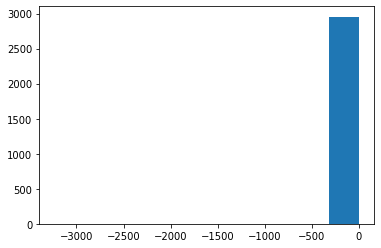

In [65]:
plt.hist(d_eta)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.958e+03]),
 array([-6.36538302e+03, -5.72879471e+03, -5.09220641e+03, -4.45561810e+03,
        -3.81902979e+03, -3.18244149e+03, -2.54585318e+03, -1.90926487e+03,
        -1.27267657e+03, -6.36088261e+02,  5.00046082e-01]),
 <a list of 10 Patch objects>)

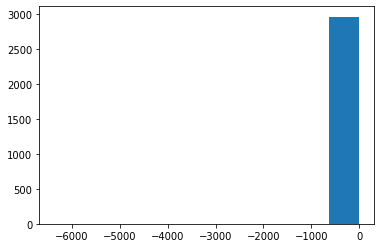

In [66]:
plt.hist(d_phi)